In [14]:
import pandas as pd
import datetime

In [15]:
#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
df


,Date,Close
0,1984-09-07,0.423880
1,1984-09-10,0.421340
2,1984-09-11,0.429020
3,1984-09-12,0.416180
4,1984-09-13,0.439270
...,...,...
9392,2021-12-16,172.259995
9393,2021-12-17,171.139999
9394,2021-12-20,169.750000
9395,2021-12-21,172.990005


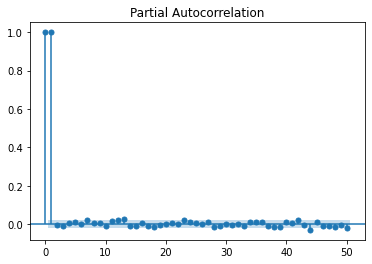

In [17]:
#use PACF to find ideal P value
#we will just use the closing values for now
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(train["Close"], lags=50)
plt.show()

We can see that the stock price is correlated strongly at a time lag of 1, (ie yesterdays price) howevever there is not much correlation between the price of two days ago. In the AFC plot you will see the correlation from the prevouse day carry over.

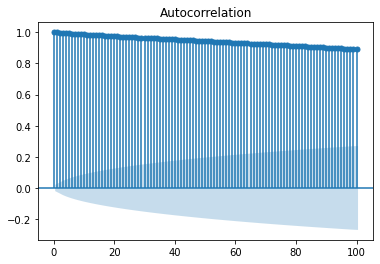

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Close"], lags= 100)
plt.show()

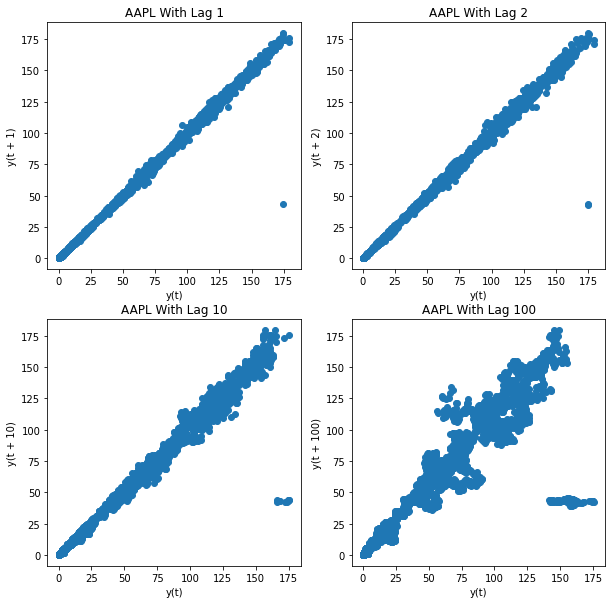

In [19]:
from pandas.plotting import lag_plot


fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (10,10))
lag_plot(df["Close"], lag=1, ax=axes[0,0])
lag_plot(df["Close"], lag=2, ax=axes[0,1])
lag_plot(df["Close"], lag=10, ax=axes[1,0])
lag_plot(df["Close"], lag=100, ax=axes[1,1])
axes[0,0].title.set_text("AAPL With Lag 1")
axes[0,1].title.set_text("AAPL With Lag 2")
axes[1,0].title.set_text("AAPL With Lag 10")
axes[1,1].title.set_text("AAPL With Lag 100")

plt.show()

In [31]:
#build the AR Model with lag 1
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from math import sqrt

model = AutoReg(train["Close"], lags = 1, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 9397
Model:                     AutoReg(1)   Log Likelihood              -17750.847
Method:               Conditional MLE   S.D. of innovations              1.600
Date:                Fri, 24 Dec 2021   AIC                              0.941
Time:                        22:26:38   BIC                              0.943
Sample:                             1   HQIC                             0.942
                                 9397                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0215      0.020      1.076      0.282      -0.018       0.061
Close.L1       0.9999      0.000   2564.335      0.000       0.999       1.001
                                    Roots           

In [21]:
pred = model_fit.predict(start=len(train), end=len(train) + len(test),dynamic=False)
pred.iloc[1]

132.6665521505912

c:\Users\BrianBeinBrohan\projects\pytorch tutorials\env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


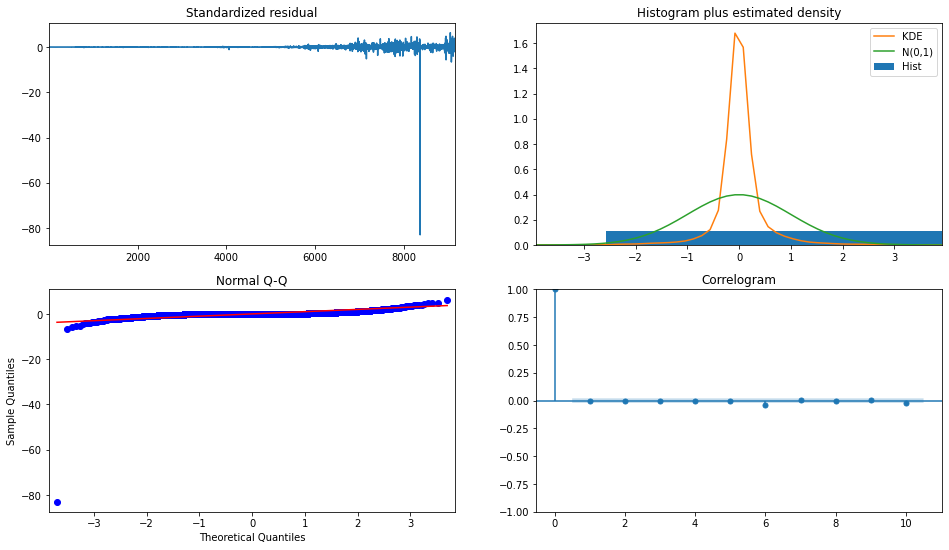

In [22]:
fig = plt.figure(figsize=(16, 9))
fig = model_fit.plot_diagnostics(fig=fig, lags=10)

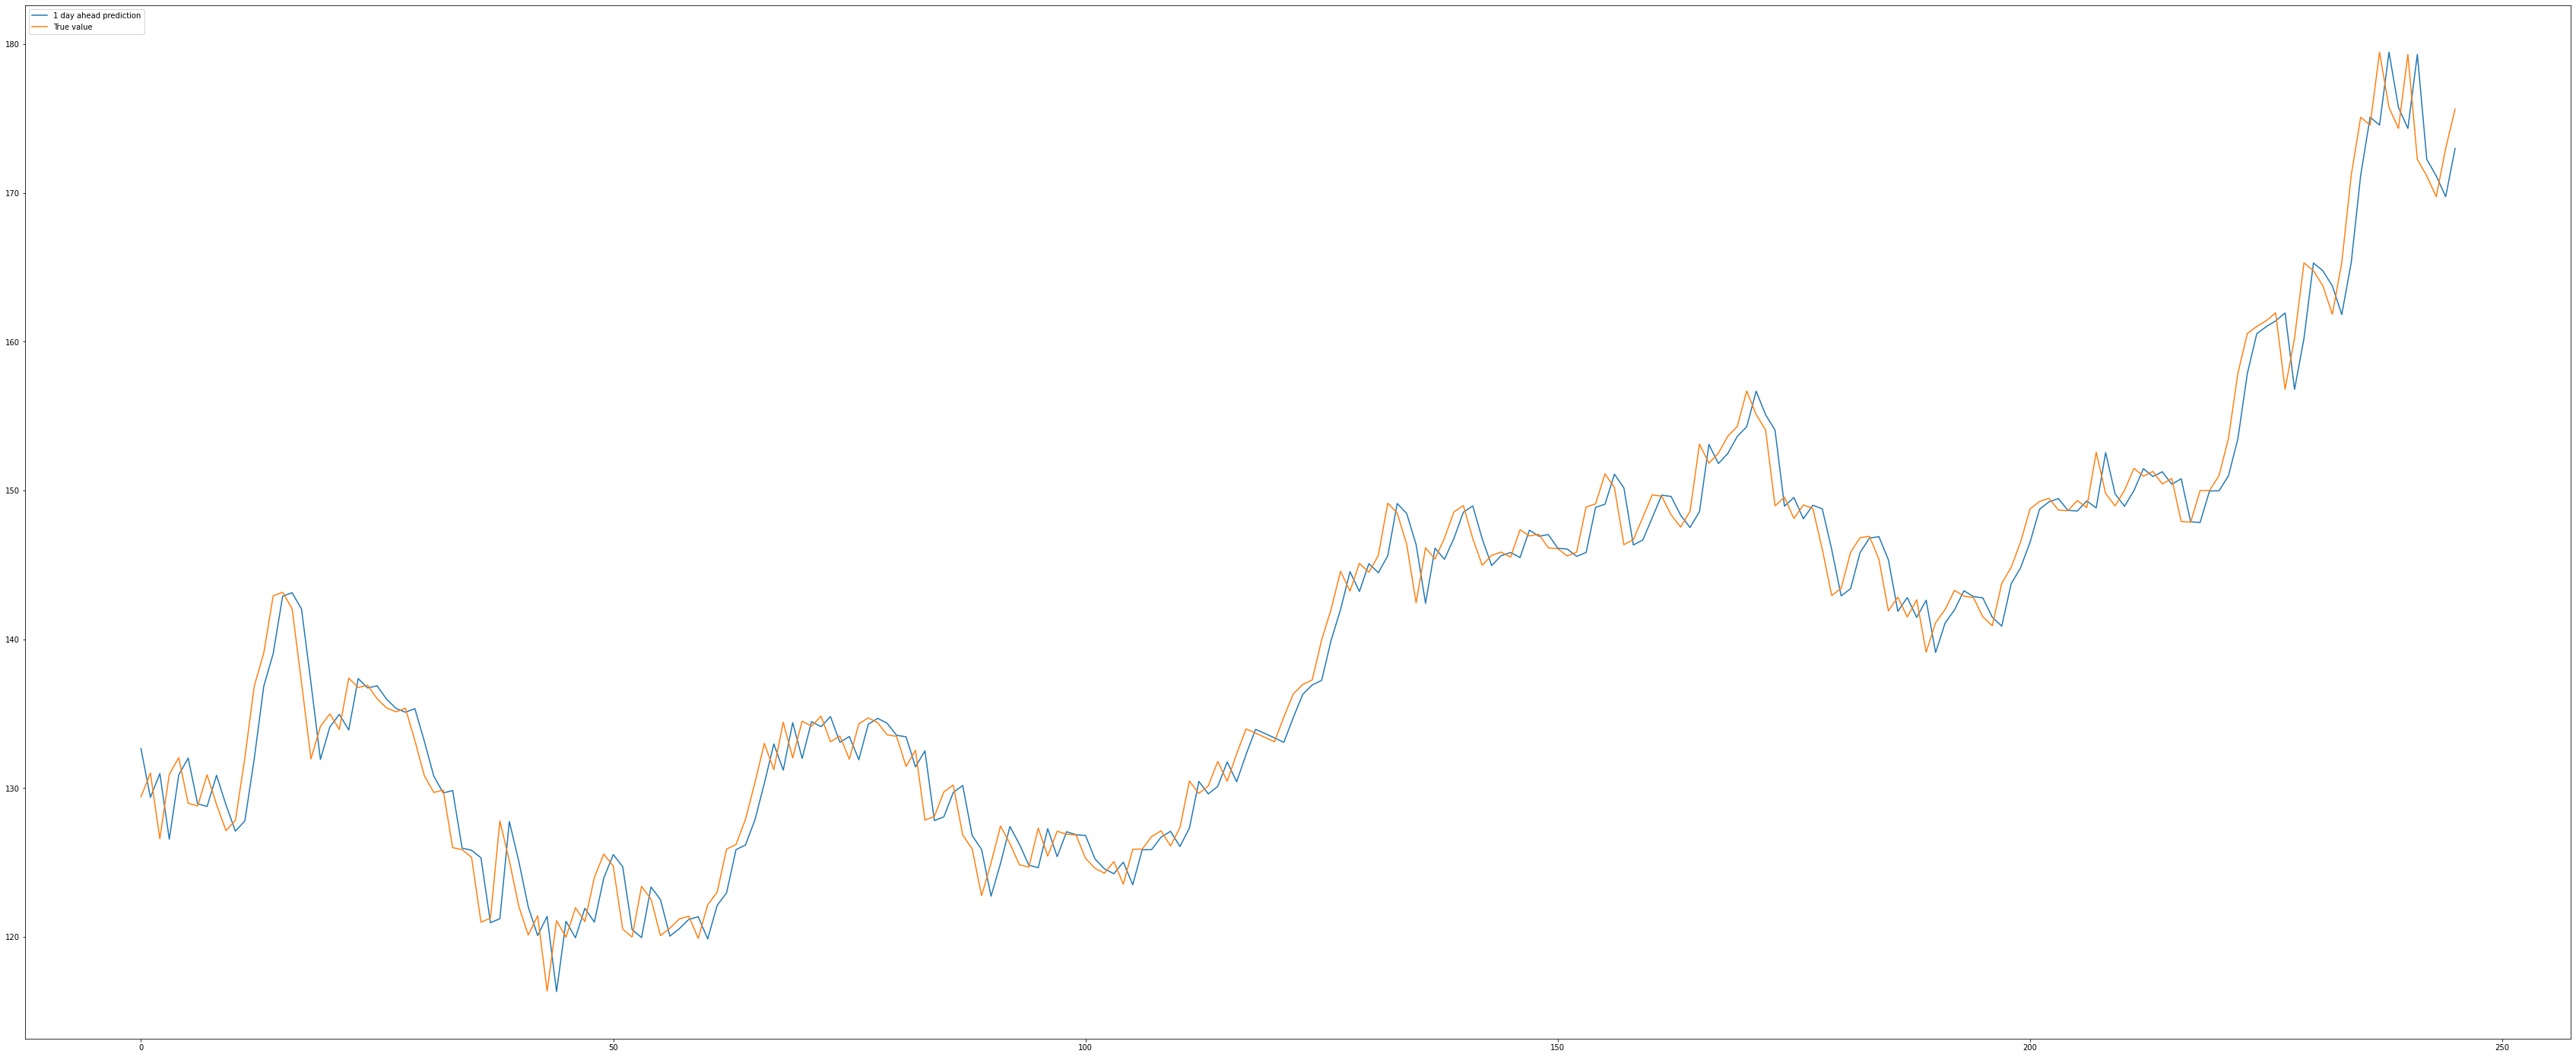

In [85]:
#now there seems to be a problem here? What is it, well we are trying to predict a years worth of data using data from a year ago, essnetially 100+ time lags back, so
#we have to keep updating the model each time lag

#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
lag_1_pred = []
#lag_2_pred = []
date = []

test = test.reset_index(drop=True)

for i in range(len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()
    lag_1_pred.append(model_fit.predict(start=len(train)-1, end=len(train) ).iloc[1])
    #lag_2_pred.append(model_fit.predict(start=len(train)-1, end=len(train) +1).iloc[1])

    date.append(test.iloc[i]["Date"])
    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)

plt.figure(figsize=(60,25))
plt.plot(lag_1_pred, label = "1 day ahead prediction")
plt.plot(test["Close"], label = "True value")
plt.legend(loc="upper left")
plt.show()

    



In [86]:
#lets check the error for a better comparison
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mean_squared_error(lag_1_pred, test["Close"].values.tolist())
mean_absolute_percentage_error(lag_1_pred, test["Close"].values.tolist())


0.012317641106891349

In [87]:
#note on the error, if we notice that since one of the graphs is predicting a day ahead
for i in range(len(lag_1_pred)-1):
    print(lag_1_pred[i+1] ,test["Close"].iloc[i]) 

mean_squared_error(lag_1_pred[1::], test["Close"].iloc[0:len(test)-1].values.tolist())

129.37578664610928 129.410004
130.97650689167165 131.009995
126.56465872574154 126.599998
130.8863811574504 130.919998
132.0169417544818 132.050003
128.94556052629665 128.979996
128.76552422069798 128.800003
130.85643132510623 130.889999
128.8756008395655 128.910004
127.1049290327093 127.139999
127.79521865620028 127.830002
131.99697930582553 132.029999
136.83948625088973 136.869995
139.04086030581908 139.070007
142.89346651870855 142.919998
143.133678294255 143.160004
142.0328979425949 142.059998
137.0595986977636 137.089996
131.92683694761914 131.960007
134.10791086490156 134.139999
134.95839081315347 134.990005
133.90786563098143 133.940002
137.35974174070427 137.389999
136.72939974483612 136.759995
136.8795250757844 136.910004
135.97903377320566 136.009995
135.35872712786448 135.389999
135.0986235017756 135.130005
135.33877168496178 135.369995
133.15767421478463 133.190002
130.80659758208924 130.839996
129.6761591546665 129.710007
129.83624184941493 129.869995
125.96480078824126 12

0.0007896635205141342

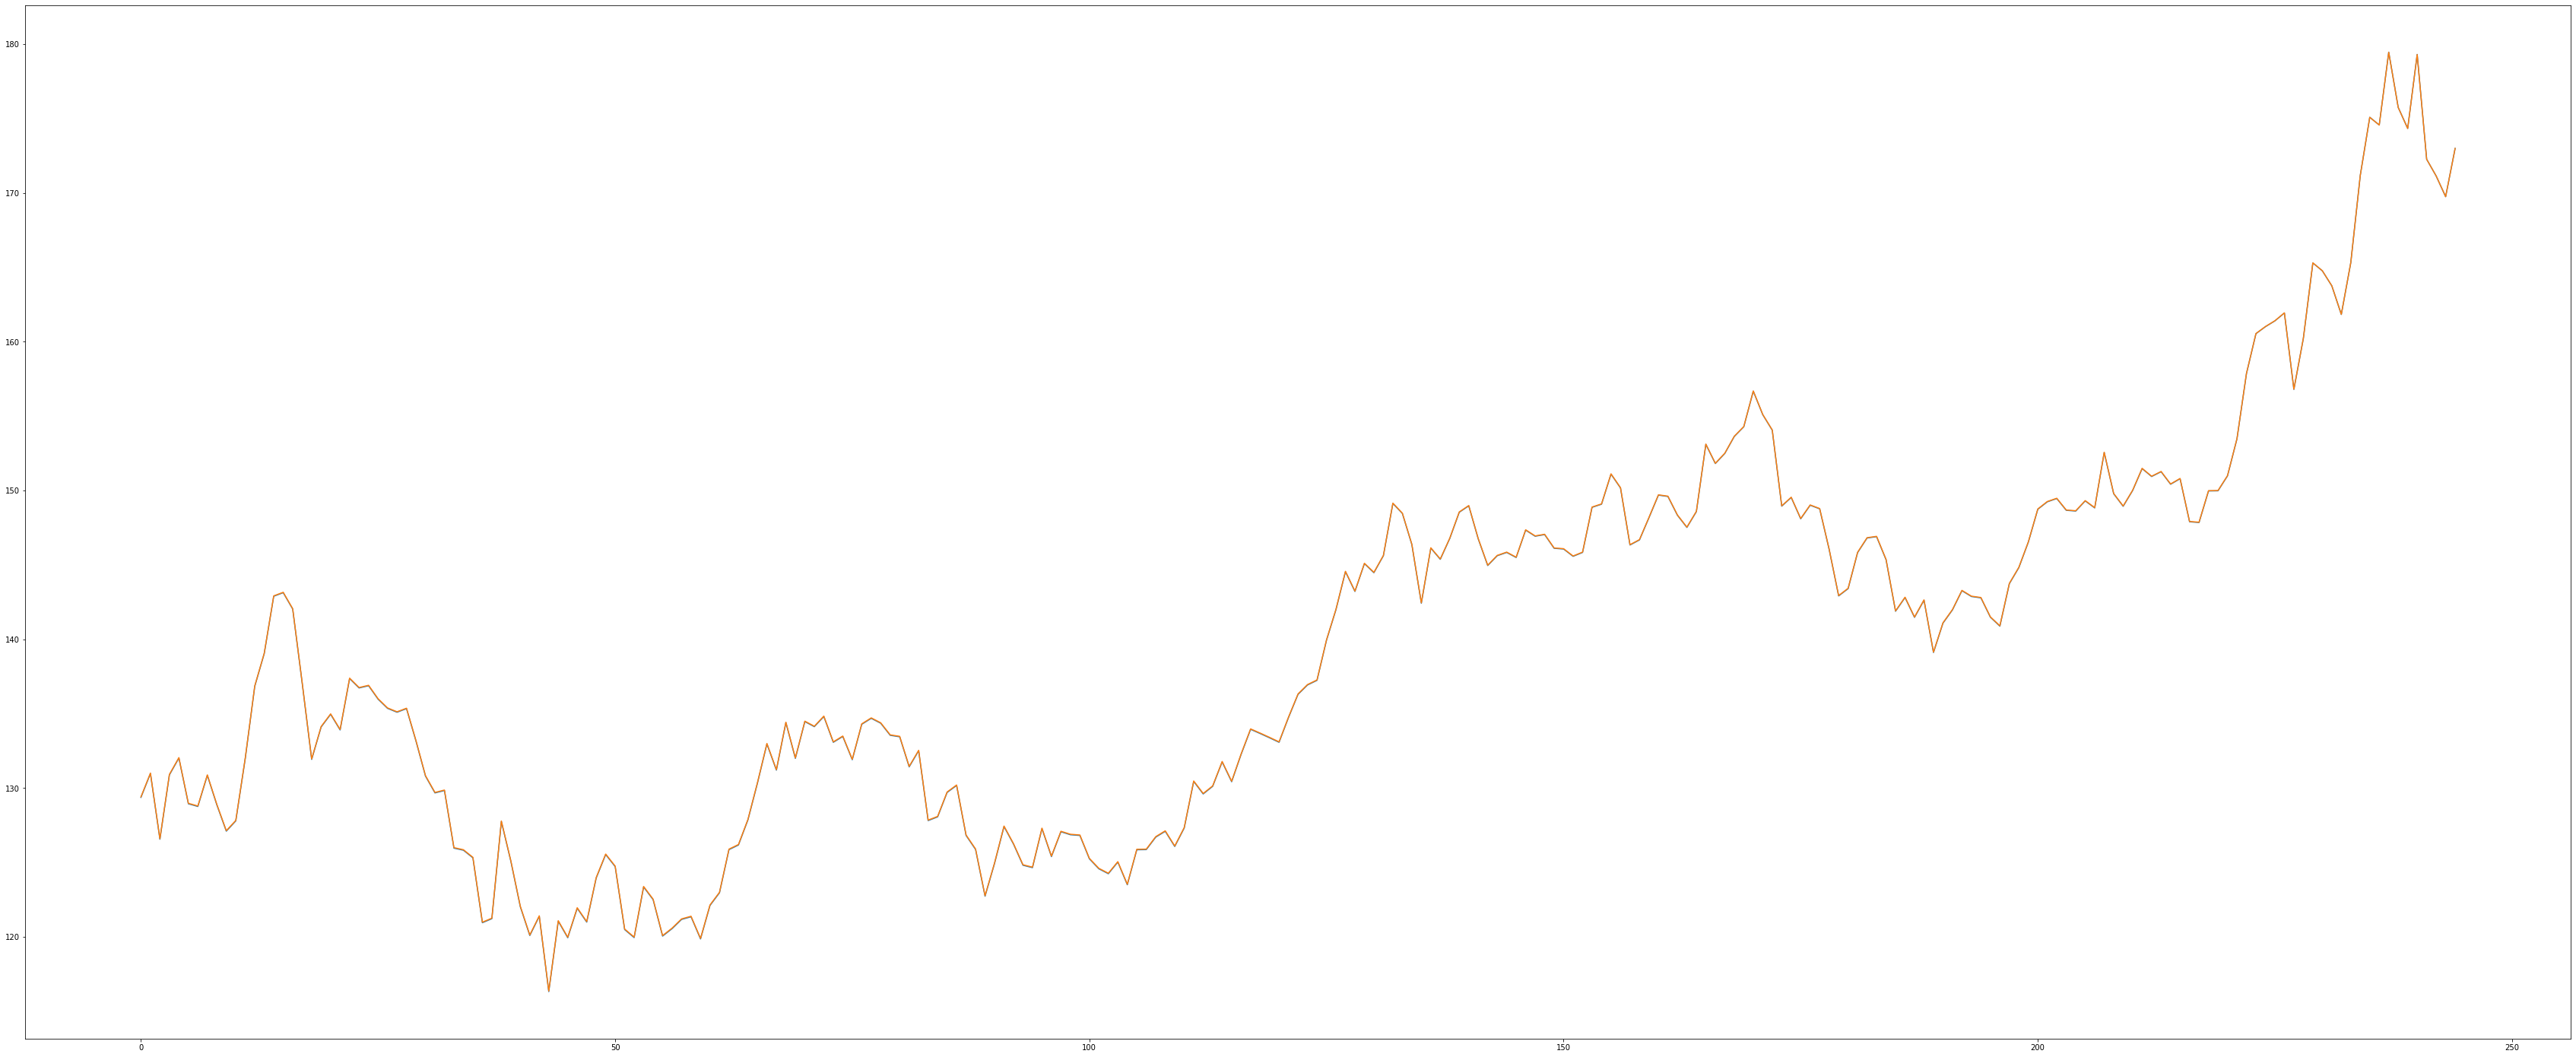

In [71]:
plt.figure(figsize=(60,25))
plt.plot(lag_1_pred[1::])
plt.plot(test["Close"].iloc[0:len(test)-1])
plt.show()

#we can see that is predicts almost perfectly